cpu


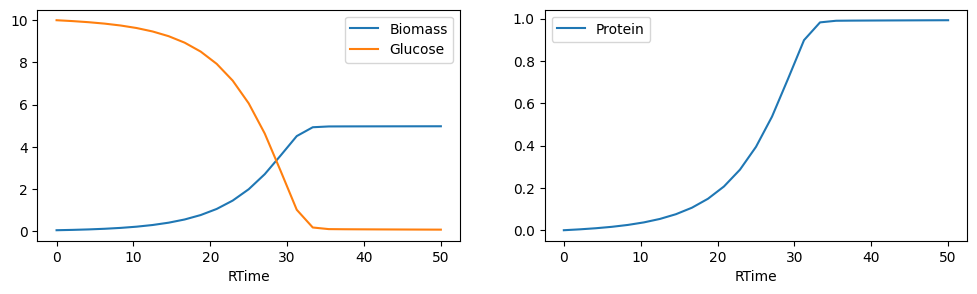

In [11]:
from typing import Union

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import torch
import torch.nn as nn
from tqdm import tqdm

pd.options.mode.chained_assignment = None
np.set_printoptions(suppress=True)
np.set_printoptions(precision=4)


DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(DEVICE)

# parameter values
mumax = 0.20      # 1/hour
Ks = 1.00         # g/liter
Yxs = 0.5         # g/g
Ypx = 0.2         # g/g
Sin = 10.0         # g/liter

# inlet flowrate
def Fs(t):
    return 0.05

# reaction rates
def mu(S):
    return mumax*S/(Ks + S)

def Rg(X,S):
    return mu(S)*X
    
def Rp(X,S):
    return Ypx*Rg(X,S)

# differential equations
def xdot(x,t):
    X,P,S,V = x
    dX = -Fs(t)*X/V + Rg(X,S)
    dP = -Fs(t)*P/V + Rp(X,S)
    dS = Fs(t)*(Sin-S)/V - Rg(X,S)/Yxs
    dV = Fs(t)
    return [dX,dP,dS,dV]

IC = [0.05, 0.0, 10.0, 1.0]

t = np.linspace(0,50,25)
sol = odeint(xdot,IC,t)
X,P,S,V = sol.transpose()

# Generate dataset 
df = pd.DataFrame({'RTime': t, 'Biomass': X, 'Glucose': S, 'V': V, 'Protein': P})

# Plot 
fig, ax = plt.subplots(1, 2, figsize=(12, 3))
df.plot(x='RTime', y=['Biomass', 'Glucose'], ax=ax[0])
df.plot(x='RTime', y='Protein', ax=ax[1])
plt.show()

In [18]:
def numpy_to_tensor(array):
    return (
        torch.tensor(array, requires_grad=True, dtype=torch.float32)
        .to(DEVICE)
        .reshape(-1, 1)
    )

class PINN(nn.Module):
    def __init__(
        self,
        input_dim: int,
        output_dim: int,
        t_start: Union[np.float32, torch.Tensor],
        t_end: Union[np.float32, torch.Tensor],
    ):
        super(PINN, self).__init__()
        self.input = nn.Linear(input_dim, 64)
        self.fc1 = nn.Linear(64, 516)
        self.fc2 = nn.Linear(516, 516)
        self.fc3 = nn.Linear(516, 64)
        self.output = nn.Linear(64, output_dim)

        # Kinetic parameters
        self.mu_max = nn.Parameter(torch.tensor([0.5]))
       
        self.t_start = t_start
        self.t_end = t_end
        if isinstance(self.t_start, torch.Tensor):
            self.t_start = self.t_start.item()
        if isinstance(self.t_end, torch.Tensor):
            self.t_end = self.t_end.item()

    def forward(self, x):
        x = torch.relu(self.input(x))
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = self.output(x)
        return x
    
def loss_fn(
    net: torch.nn.Module,
    t_start: Union[np.float32, torch.Tensor],
    t_end: Union[np.float32, torch.Tensor],
) -> torch.Tensor:
    
    if isinstance(t_start, torch.Tensor):
        t_start = t_start.item()
    if isinstance(t_end, torch.Tensor):
        t_end = t_end.item()

    t = torch.linspace(t_start, t_end, steps=100).view(-1, 1).requires_grad_(True)
    F = torch.tensor([Fs(t) for t in t], dtype=torch.float32).view(-1, 1)

    u_pred = net.forward(t)
    X_pred = u_pred[:, 0].view(-1, 1)
    S_pred = u_pred[:, 1].view(-1, 1)
    V_pred = u_pred[:, 2].view(-1, 1)
    P_pred = u_pred[:, 3].view(-1, 1) 

    dXdt_pred = torch.autograd.grad(X_pred, t, grad_outputs=torch.ones_like(X_pred), create_graph=True)[0]
    dSdt_pred = torch.autograd.grad(S_pred, t, grad_outputs=torch.ones_like(S_pred), create_graph=True)[0]
    dVdt_pred = torch.autograd.grad(V_pred, t, grad_outputs=torch.ones_like(V_pred), create_graph=True)[0]
    dPdt_pred = torch.autograd.grad(P_pred, t, grad_outputs=torch.ones_like(P_pred), create_graph=True)[0]

    mu = net.mu_max * S_pred / (Ks + S_pred)
    
    error_dXdt = nn.MSELoss()(
        dXdt_pred, mu * X_pred - X_pred * F / V_pred
    )
    error_dSdt = nn.MSELoss()(
        dSdt_pred, - mu * X_pred / Yxs + F / V_pred * (Sin - S_pred)
    )
    error_dVdt = nn.MSELoss()(
        dVdt_pred, F
    )
    error_dPdt = nn.MSELoss()(
        dPdt_pred, Ypx * mu * X_pred - P_pred * F / V_pred
    )

    error_ode = error_dXdt + error_dSdt + error_dVdt + error_dPdt

    return error_ode


In [20]:
t_start, t_end = df['RTime'].min(), df['RTime'].max()
t_train = numpy_to_tensor(df['RTime'].values)
X_train = numpy_to_tensor(df['Biomass'].values)
S_train = numpy_to_tensor(df["Glucose"].values)
P_train = numpy_to_tensor(df["Protein"].values)
V_train = numpy_to_tensor(df["V"].values)

u_train = torch.cat((X_train, S_train, V_train, P_train), dim=1).to(DEVICE)

net = PINN(1, 4, t_start, t_end).to(DEVICE)

optimizer = torch.optim.Adam(net.parameters(), lr=5e-5)
w_data, w_ode, w_ic = 1.0, 0.25, 0.25

n_epochs = 10000
for epoch in range(n_epochs):
    optimizer.zero_grad()
    u_pred = net.forward(t_train)

    loss_data = nn.MSELoss()(u_pred, u_train) * w_data
    loss_ode = loss_fn(net, t_start, t_end) * w_ode
    loss_ic = nn.MSELoss()(u_pred[0, :], u_train[0, :]) * w_ic

    loss = loss_data + loss_ode
    loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
        print(
            f"Epoch {epoch+1}/{n_epochs}, Loss: {loss.item():.4f}, Loss Data: {loss_data.item():.4f}, Loss ODE: {loss_ode.item():.4f}, mu_max: {net.mu_max.item():.4f}"
        )


u_pred = pd.DataFrame(net.forward(t_train).detach().cpu().numpy())
u_pred.columns = ["Biomass", "Glucose", "V", "Protein"]
u_pred['RTime'] = t_train.detach().cpu().numpy()

Epoch 1/10000, Loss: 18.0428, Loss Data: 15.4506, Loss ODE: 2.5922, mu_max: 0.5001
Epoch 101/10000, Loss: 10.5739, Loss Data: 9.9697, Loss ODE: 0.6042, mu_max: 0.4957
Epoch 201/10000, Loss: 6.8653, Loss Data: 6.5893, Loss ODE: 0.2761, mu_max: 0.4896
Epoch 301/10000, Loss: 3.8262, Loss Data: 3.4899, Loss ODE: 0.3363, mu_max: 0.4848
Epoch 401/10000, Loss: 0.7177, Loss Data: 0.4069, Loss ODE: 0.3108, mu_max: 0.4811
Epoch 501/10000, Loss: 0.5153, Loss Data: 0.2565, Loss ODE: 0.2588, mu_max: 0.4777
Epoch 601/10000, Loss: 0.4521, Loss Data: 0.2180, Loss ODE: 0.2341, mu_max: 0.4744
Epoch 701/10000, Loss: 0.3797, Loss Data: 0.1786, Loss ODE: 0.2011, mu_max: 0.4711
Epoch 801/10000, Loss: 0.3134, Loss Data: 0.1465, Loss ODE: 0.1669, mu_max: 0.4680
Epoch 901/10000, Loss: 0.2608, Loss Data: 0.1224, Loss ODE: 0.1384, mu_max: 0.4652
Epoch 1001/10000, Loss: 0.2119, Loss Data: 0.1028, Loss ODE: 0.1091, mu_max: 0.4626
Epoch 1101/10000, Loss: 0.1674, Loss Data: 0.0877, Loss ODE: 0.0797, mu_max: 0.4604
E

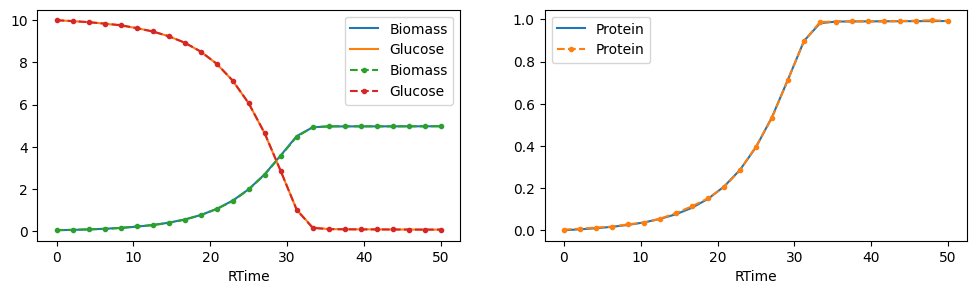

In [21]:
fig, ax = plt.subplots(1, 2, figsize=(12, 3))
df.plot(x='RTime', y=['Biomass', 'Glucose'], ax=ax[0])
df.plot(x='RTime', y='Protein', ax=ax[1])
u_pred.plot(x='RTime', y=['Biomass', 'Glucose'], ax=ax[0], marker='o', linestyle='--', markersize=3)
u_pred.plot(x='RTime', y='Protein', ax=ax[1], marker='o', linestyle='--', markersize=3)
plt.show()